In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [2]:
# Load online retail transactional data set
ORC = pd.read_excel('../input/online-retail-data-set-from-uci-ml-repo/Online Retail.xlsx')
print("Retail transactions in the data set : {}".format(ORC.shape[0]))

Retail transactions in the data set : 541909


# Data Exploration

In [3]:
# First five transactions
ORC.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Summary of data set.
ORC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
print("Duplicate transactions : {}".format(ORC.duplicated().sum()))

Duplicate transactions : 5268


In [6]:
# First five duplicate transactions
ORC[ORC.duplicated()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom


In [7]:
# Select transactions with InvoiceNo = '536409' & StockCode = '21866'
ORC.loc[(ORC['InvoiceNo'].astype(str) == '536409') & (ORC['StockCode'].astype(str) == '21866')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom


In [8]:
# Remove duplicates
ORC = ORC.drop(index=ORC[ORC.duplicated()].index)
print("Retail transactions after duplicates removal : {}".format(ORC.shape[0]))

Retail transactions after duplicates removal : 536641


In [9]:
# Detect missing values
ORC.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [10]:
# Descriptive statistics for StockCode.
ORC['StockCode'].describe()

count     536641
unique      4070
top       85123A
freq        2301
Name: StockCode, dtype: object

**There are 4070 unique prodict codes. '85123A' is the most common product code appeared 2301 times.**

In [11]:
# Descriptive statistics for Quantity.
ORC['Quantity'].describe()

count    536641.000000
mean          9.620029
std         219.130156
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [12]:
# Inspect min and max Quantity transactions
ORC.loc[(ORC['Quantity']==-80995) | (ORC['Quantity']==80995)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


**Invoice No. 581483 of 80995 quantity sell of stock code 23843 is reversed by adding a contra entry. Invoice No. of such reversal/cancelled entries starts with letter 'C' **

In [13]:
# Cancelled/Reversed invoices
print("Cancelled invoices/transactions : {}".format(ORC[ORC['InvoiceNo'].astype(str).str[0] == 'C'].shape[0]))

Cancelled invoices/transactions : 9251


In [14]:
# Descriptive statistics for UnitPrice
ORC['UnitPrice'].describe()

count    536641.000000
mean          4.632656
std          97.233118
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

In [15]:
# Display transactions with negative unit price.
ORC[ORC['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


**Above transactions are looking to be a manual ledger adjustments. Also they don't have customer id.**

In [16]:
# Dsiplay transaction with unit price > 10000
ORC[ORC['UnitPrice'] > 10000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,NaN,United Kingdom
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,13474.79,NaN,United Kingdom
16356,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,NaN,United Kingdom
43702,C540117,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:55:00,16888.02,NaN,United Kingdom
43703,C540118,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:57:00,16453.71,NaN,United Kingdom
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
524601,C580604,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:35:00,11586.50,NaN,United Kingdom
524602,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836.46,NaN,United Kingdom


**Most of the higher unit price transactions are related to Amazon fee for selling the product through their platform. Such transactions don't have customer id.**

In [17]:
print("Transactions with zero unit price : {}".format(ORC[ORC['UnitPrice'] == 0].shape[0]))

Transactions with zero unit price : 2510


In [18]:
#First five transactions with zero unit price
ORC[ORC['UnitPrice'] == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


In [19]:
# top 10 selling products by their counts in data set.
ORC['Description'].value_counts().sort_values(ascending=False)[:10]

WHITE HANGING HEART T-LIGHT HOLDER    2357
REGENCY CAKESTAND 3 TIER              2189
JUMBO BAG RED RETROSPOT               2156
PARTY BUNTING                         1720
LUNCH BAG RED RETROSPOT               1625
ASSORTED COLOUR BIRD ORNAMENT         1488
SET OF 3 CAKE TINS PANTRY DESIGN      1465
PACK OF 72 RETROSPOT CAKE CASES       1367
LUNCH BAG  BLACK SKULL.               1323
NATURAL SLATE HEART CHALKBOARD        1272
Name: Description, dtype: int64

In [20]:
# Descriptive Statistics for Country
ORC['Country'].describe()

count             536641
unique                38
top       United Kingdom
freq              490300
Name: Country, dtype: object

**Majority of customers resides in United Kingdom**

In [21]:
#Remove transactions with missing customer ids
ORC = ORC.drop(index=ORC[ORC['CustomerID'].isnull()].index)
print("Retail transactions after removing missing customer ids  : {}".format(ORC.shape[0]))

Retail transactions after removing missing customer ids  : 401604


In [22]:
import datetime as dt

ORC['InvoiceDate'] = pd.to_datetime(ORC['InvoiceDate'])
#ORC['SalesAmount'] = ORC['Quantity'] * ORC['UnitPrice']
ORC['Month'] = ORC['InvoiceDate'].dt.month
ORC['Day'] = ORC['InvoiceDate'].dt.day
ORC['Hour'] = ORC['InvoiceDate'].dt.hour

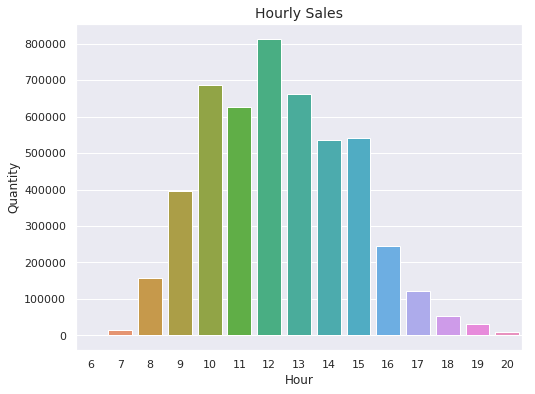

In [23]:
hourly_sales = ORC[['Hour', 'Quantity']].groupby('Hour').sum()
#hourly_sales.plot(kind='bar')
plt.figure(figsize=(8,6))
plt.title("Hourly Sales", fontsize=14)
sns.barplot(hourly_sales.index, hourly_sales['Quantity'])

**The majority of the sales happens in between 10am to 3pm**

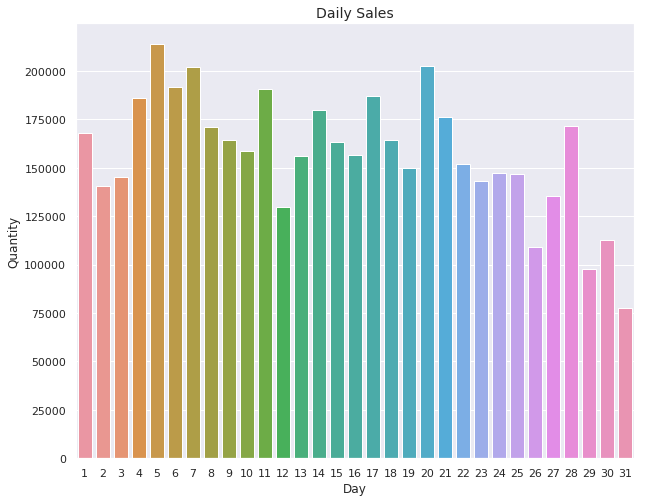

In [24]:
daily_sales = ORC[['Day', 'Quantity']].groupby('Day').sum()
plt.figure(figsize=(10,8))
plt.title("Daily Sales", fontsize=14)
sns.barplot(daily_sales.index, daily_sales['Quantity'])

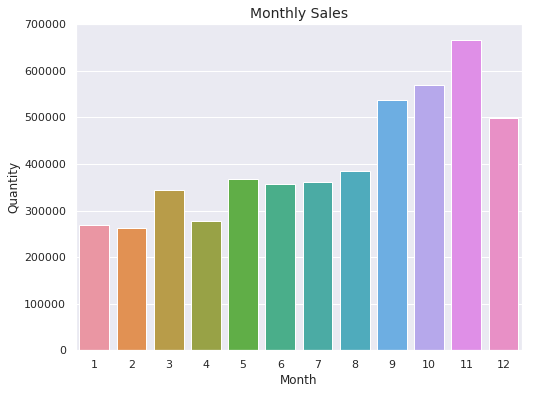

In [25]:
monthly_sales = ORC[['Month', 'Quantity']].groupby('Month').sum()
plt.figure(figsize=(8,6))
plt.title("Monthly Sales", fontsize=14)
sns.barplot(monthly_sales.index, monthly_sales['Quantity'])

**Most of the sales happened in between September and December month (Christmas festive sales)**

# Customer RFM (Recency, Frequency, Monetary) analysis
[https://clevertap.com/blog/rfm-analysis/]

In [26]:
# Recency -> The freshness of customer purchase

# Calculate latest date from data set.
max_date = ORC['InvoiceDate'].max()
# Calculate days passed since customer's last purchase.
ORC['Days_passed'] = max_date -  ORC['InvoiceDate']
ORC['Days_passed'] = ORC['Days_passed'].dt.days
# Group Recency by customer id
recency = ORC[['CustomerID', 'Days_passed']].groupby('CustomerID').min()
recency.head(5)

,Days_passed
CustomerID,
12346.0,325
12347.0,1
12348.0,74
12349.0,18
12350.0,309


In [27]:
# Frequency of the customer transactions
frequency = ORC[['CustomerID','InvoiceNo']].groupby('CustomerID').count()
frequency.head()

,InvoiceNo
CustomerID,
12346.0,2
12347.0,182
12348.0,31
12349.0,73
12350.0,17


In [28]:
# Monetory -> purchasing power of the customer
ORC['SaleAmount'] = ORC['Quantity'] * ORC['UnitPrice']
monetory = ORC[['CustomerID', 'SaleAmount']].groupby('CustomerID').sum()
monetory.head()

,SaleAmount
CustomerID,
12346.0,0.00
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40


In [29]:
# Merge recency, frequency and monetory dataframes
RFM = recency.merge(frequency,on='CustomerID').merge(monetory, on='CustomerID')
RFM = RFM.rename(columns={"Days_passed": "Recency", "InvoiceNo": "Frequency", "SaleAmount" : "Monetory"})
RFM.head()

,Recency,Frequency,Monetory
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


# KMeans clustering

**Selecting the number of clusters with silhouette analysis on KMeans clustering**
**[https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py]**

In [30]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=5)
    cluster_labels = clusterer.fit_predict(RFM)
    
    silhouette_avg = silhouette_score(RFM, cluster_labels)
    print("for n_clusters =", n_clusters, "Average Silhouette score = ", silhouette_avg)

for n_clusters = 2 Average Silhouette score =  0.98630357275616
for n_clusters = 3 Average Silhouette score =  0.9630745414576583
for n_clusters = 4 Average Silhouette score =  0.8770783791563798
for n_clusters = 5 Average Silhouette score =  0.8148946297109425
for n_clusters = 6 Average Silhouette score =  0.7754320568833175
for n_clusters = 7 Average Silhouette score =  0.7754383143667688
for n_clusters = 8 Average Silhouette score =  0.7213953316267048


In [31]:
# Kmeans with number of clusers = 4
clusterer = KMeans(n_clusters=4, random_state=5)
cluster_labels = clusterer.fit_predict(RFM)

In [32]:
RFM['Cluster'] = cluster_labels
RFM.groupby('Cluster').mean()

,Recency,Frequency,Monetory
Cluster,,,
0,93.502007,75.426919,1128.677111
1,2.666667,956.000000,241083.226667
2,6.866667,1508.466667,71538.928000
3,16.521008,476.268908,14304.523193


**Cluster 0 contains group of customers with low value of Recency, Frequency and Monetory**    
**Cluster 1 contains group of customers with high Monetory value**     
**Cluster 2 contains group of customers with high Frequnecy value**    
**Cluster 3 contains group of customers with moderate value of Recency, Frequnecy and Monetory**      

# Principal component analysis (PCA)

In [33]:
# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(),
                    PCA(n_components=2, random_state=43))
RFM_transformed = pca.fit_transform(RFM)

Text(0.5, 1.0, 'Clusters')

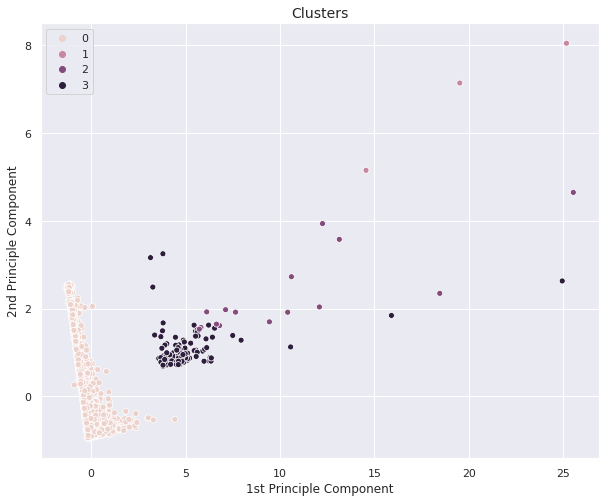

In [34]:
plt.figure(figsize=(10,8))
sns.scatterplot(RFM_transformed[:,0], RFM_transformed[:,1], hue=cluster_labels)
plt.xlabel('1st Principle Component')
plt.ylabel('2nd Principle Component')
plt.title("Clusters", fontsize=14)